In [9]:
import requests
import pytz
import pandas as pd
import sqlite3 as db
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import scipy.optimize as opt
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
%matplotlib inline

sectors = ['SPY','SSO']
sec_etf = pdr.get_data_yahoo(sectors,start='2015-4-3', end='2018-4-3')
sectors_r = sec_etf['Adj Close'].pct_change().dropna(axis=0, how='any')
sectors_r.head(10)

[*********************100%***********************]  2 of 2 downloaded


,SPY,SSO
Date,,
2015-04-07,-0.002646,-0.004733
2015-04-08,0.003377,0.006059
2015-04-09,0.004423,0.009071
2015-04-10,0.005457,0.010350
2015-04-13,-0.004523,-0.008599
2015-04-14,0.001913,0.003545
2015-04-15,0.004487,0.008868
2015-04-16,-0.000285,-0.000670
2015-04-17,-0.011504,-0.022960


In [10]:
sectors_s = sec_etf['Adj Close'].dropna(axis=0, how='any')
sectors_s.head(10)

,SPY,SSO
Date,,
2015-04-06,195.634811,64.480896
2015-04-07,195.117081,64.175735
2015-04-08,195.776016,64.564575
2015-04-09,196.642029,65.150261
2015-04-10,197.715118,65.824570
2015-04-13,196.820892,65.258553
2015-04-14,197.197418,65.489876
2015-04-15,198.082245,66.070656
2015-04-16,198.025757,66.026360


In [18]:
file = 'Borrow_2018_4_4 copy.csv'
df_etf = pd.read_csv(file)
df_etf = df_etf.reset_index().rename(columns={'#BOF':'#SYM','2018.04.04':'CUR','13:00:02':'NAME','Unnamed: 3':'CON',
                                              'Unnamed: 4':'ISIN','Unnamed: 5':'REBATERATE','Unnamed: 6':'FEERATE','Unnamed: 7':'AVAILABLE'})
df_etf.head()
df_etf = df_etf.set_index(['#SYM'])
print(df_etf.loc['SPY'])
print(df_etf.loc['SSO'])

index                              10443
CUR                                  USD
NAME          SPDR S&amp;P 500 ETF TRUST
CON                               756733
ISIN                        XXXXXXXF1030
REBATERATE                        1.2437
FEERATE                           0.4363
AVAILABLE                        8400000
Name: SPY, dtype: object
index                              10534
CUR                                  USD
NAME          PROSHARES ULTRA S&amp;P500
CON                             39622943
ISIN                        XXXXXXXR1077
REBATERATE                       -1.4972
FEERATE                           3.1772
AVAILABLE                         550000
Name: SSO, dtype: object


In [54]:
import numpy as np
L = []
S = []
M = []
beta  = 1
r = 1.2437 #rebate rate of underlying ETF
f = 0.4363 #fee rate of underlying ETF
for j in range(len(sectors_s)):
    #ret_s = sectors_s['SSO'][i] - sectors_s['SSO'][i-1]
    S.append(sectors_s.iloc[j]['SPY']) # underlying ETF
    L.append(sectors_s.iloc[j]['SSO']) # leveraged ETF
#print(S)
for i in range(len(S)):
    interest = (1 - beta) * r/100 * ((i+1)/252) - f/100 * (i+1)/252 #r is rebate rate, f is fee rate
    volatility = -0.5 * (beta **2 - beta)* np.std(S[:i]) *i/252
    q = (sectors_s['SSO'][i]/sectors_s['SSO'][0]) **(beta) * np.exp(interest + volatility)
    M.append(q * L[0]) # Model's leveraged ETF
print(M)

/Users/zhousq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/zhousq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/zhousq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan, 64.17351282631662, 64.56122157231954, 65.14574924212334, 65.8188719807837, 65.25177423146191, 65.48193947180272, 66.061505323509, 66.01607247979028, 64.49925396002365, 65.67915631774515, 65.51564593052011, 66.14927874918412, 66.47782656046144, 66.77682264807859, 66.21474092491498, 66.64166051551338, 66.07466609331283, 64.78935262520677, 66.15110090248166, 66.57308073661987, 65.02214155531827, 64.46507023207921, 64.97070151689947, 66.70130193937256, 66.03108336428537, 65.63637816472226, 65.67459069954089, 67.02627524242067, 67.1727041150737, 67.56997922466529, 67.51470834447966, 67.42008684818043, 67.83209828829234, 67.51612770351555, 66.0786822633682, 67.24818206676386, 67.128969467012, 66.2621349621751, 66.5364249259128, 66.43691580194626, 66.80954765615944, 65.7362364545506, 65.44000522630311, 64.59298153738719, 64.59186321699502, 66.12510984272275, 66.53705055960866, 65.542524678247, 64.92178652524085, 65.63861029282921, 65.85382400103458, 67.16070304225566, 66.3531275568537, 

In [69]:
Date = sectors_r.index
print(len(Date))
print(len(L[1:]))
print(len(M[1:]))
df = pd.DataFrame({'Date':Date,'Leveraged ETF':L[1:], 'Model Leveraged ETF':M[1:]})
print(df)
print(len(Date))

754
754
754
          Date  Leveraged ETF  Model Leveraged ETF
0   2015-04-07      64.175735            64.173513
1   2015-04-08      64.564575            64.561222
2   2015-04-09      65.150261            65.145749
3   2015-04-10      65.824570            65.818872
4   2015-04-13      65.258553            65.251774
5   2015-04-14      65.489876            65.481939
6   2015-04-15      66.070656            66.061505
7   2015-04-16      66.026360            66.016072
8   2015-04-17      64.510422            64.499254
9   2015-04-20      65.691666            65.679156
10  2015-04-21      65.529259            65.515646
11  2015-04-22      66.164169            66.149279
12  2015-04-23      66.493942            66.477827
13  2015-04-24      66.794167            66.776823
14  2015-04-27      66.233086            66.214741
15  2015-04-28      66.661278            66.641661
16  2015-04-29      66.095261            66.074666
17  2015-04-30      64.810669            64.789353
18  2015-05-01     

In [101]:
df.set_index('Date')

,Leveraged ETF,Model Leveraged ETF
Date,,
2015-04-07,64.175735,64.173513
2015-04-08,64.564575,64.561222
2015-04-09,65.150261,65.145749
2015-04-10,65.824570,65.818872
2015-04-13,65.258553,65.251774
2015-04-14,65.489876,65.481939
2015-04-15,66.070656,66.061505
2015-04-16,66.026360,66.016072
2015-04-17,64.510422,64.499254


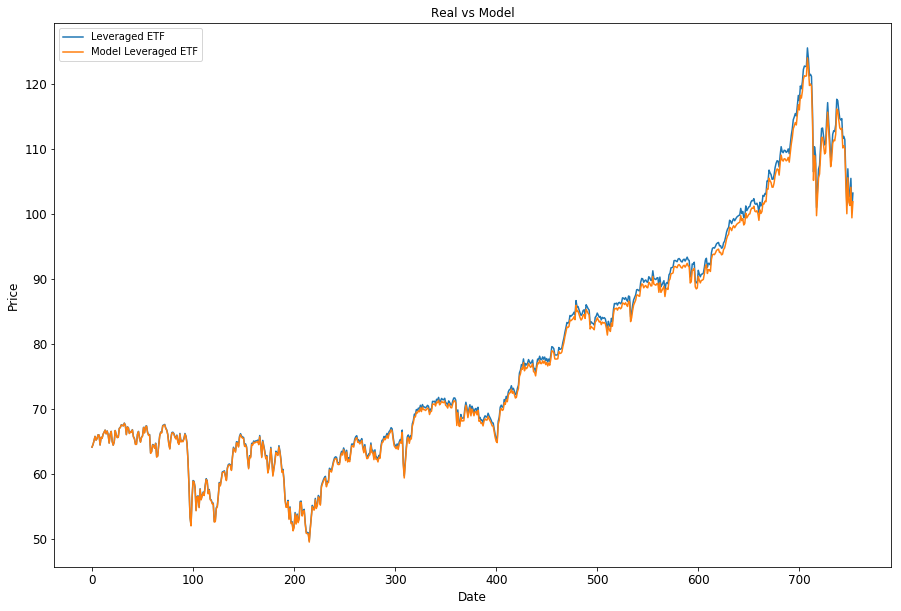

In [105]:
import pandas as pd
import matplotlib.pyplot as plt    
#plt.style.use('ggplot')
df.set_index('Date')
ax = df[['Leveraged ETF','Model Leveraged ETF']].plot(title ='Real vs Model',figsize=(15,10),legend=True, fontsize=12)
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Price',fontsize=12)
plt.show()

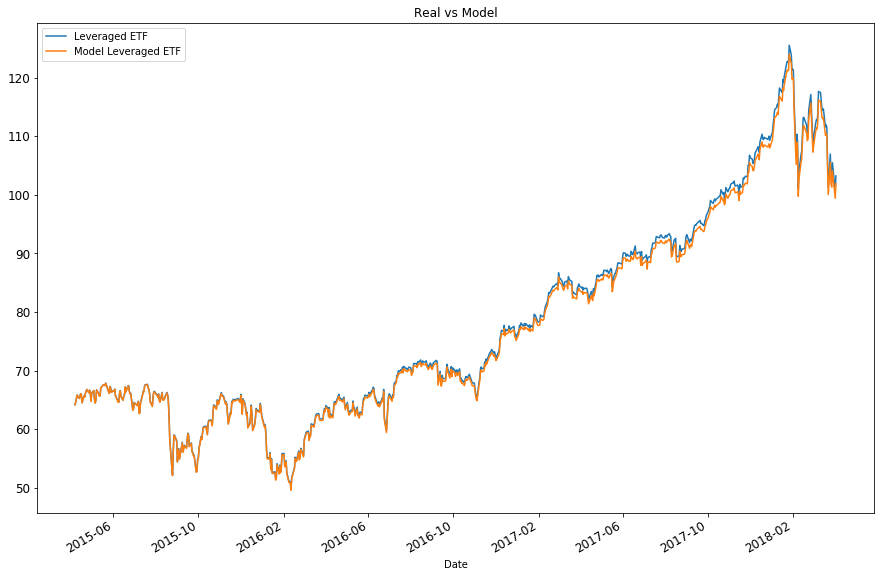

In [108]:
df.set_index('Date').plot(title ='Real vs Model',figsize=(15,10),legend=True, fontsize=12)
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Price',fontsize=12)
plt.show()